In [2]:
%run lta_datamall_data.ipynb

['https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202409/origin_destination_bus_202409.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjELr%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLXNvdXRoZWFzdC0xIkcwRQIgIzkJ57DpXY9yajMutC4VxqY2qbOBjtJ8%2BwfaI76l6DACIQCZCNE4IgJo0eCzckhkoYKSCWCfTltaIR%2BCcTB7MP1I6yrCBQgzEAQaDDM0MDY0NTM4MTMwNCIMLsRD6J%2BfEesYkSxUKp8Fk5tgl9u8dpjPP%2BmkFYUS2JVOp66XVf21MDF3mWqJWmLdht0oDvUNvn7M5ZOJu4%2BqS1eaS7uwLxXQweZmL9C2j0TTfvW4qgyxVOos1cU9k2boTEa5YilezrT1QhsoE4RrobaVjcRxMI5tGnYFAuAZG7HeAYD5JLVsmXZoITkZwkHLfCSC7xaIHAKSai%2Bt7IvHlTrMBqGPFSbIbuL8XPiVqkdTFPAhkNFjE7jtDiDjHF7fpu%2BpZYAAHfdrVukDsqigAt6dxwPh2nnP%2FhlxVIlrftfJRDecRDGnzC72ZD5YS52hVw0e0s0v44nTjiVUuG1mQGr74piP%2FmsdX2xsmWnlKY7WmJ%2BoBBw9yS85AxEWptTHEcUkyl4lnU5G2DAJMv%2F4gYo%2BCY2L1P5CiKqapIFMSqZ3IwPZ6J4c%2BRBRH0UbRYP%2BeJUSPQAx5KMhwf5EnDUKjQbC%2BrYR%2BqPrBmVF7%2FA4la4GgBHzaaOdgNbl5yZRqo%2B6t97ZVg53hVAwe6dkiFwrpYG1W6mxtjM5QcqG4BXTkHA9arNcva3N4wUTNSum3uQvdqz1Zk81KsDR5j9i%2B86H639uiSHO7tOA%2Bqm0Kl2vCsb7MjBFD3K0KMArCmhP49tiv%2F

In [3]:
%run nearest_mrt_station_to_bus_stops.ipynb

['https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202409/origin_destination_bus_202409.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjELv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLXNvdXRoZWFzdC0xIkgwRgIhALDcgvFSYH8ZwMXg527bvDWBdVlZ5ZfVAWqNDhB5D7rMAiEAoZMAMD7k7DkkiztY967dgNOho463OtIpSnwX%2FcIMLNQqwgUINBAEGgwzNDA2NDUzODEzMDQiDD3H%2B1jeZapCX2CRpSqfBZKlNmCdJ2hbEWBZUaBUmZBnT%2FDcg0vS%2B91czdPlg5aXCbGHoGOs7%2FlraJDbO8hmrRzJU3p5B58MjpXm5ZB6JQzZfh9Q4hn20rMWsUZ9aCdMTBtB28H2zubdsY6CyWeAvcSG6G3JQ%2FglKMcC6pfNervLuY0cucoAi3xx72wqQD7Eme2OljHywEILK9BxmOVns0BNpt0hOyQOeow%2Fg5OIS4Y2R7hBcH6rptlLPMXtSsMDlIu5KVZkLMNniF%2FNkbsx1Er5EsgkDrsAsY%2FSH%2Ba579KEELNdnYL7CwL9IPorvJ5sMK3qNeh7xQaTN1EPGHekxmtj1TpwjGhcNZuNkz%2FA3YqgFf5UZ8NbV1PTSX5%2Bdd2zwZs8WPYXmL8t0sqoexK96reE4e%2BMQxVVGTuEzfF8PCpijWduwQHqdrcW9Yg1yBpW04nW6u7P7J58r9vh3Hku2lH176upeER7psX1s5YPQJXy5hqo7tfEuOnBfrNMQCWOL%2BIOd%2BkK8spuJuZlbRTX0tJtePAHX3oqKh2LmXZME59NAT2Fb%2BM8z5vWGov3IgXhQUUsiOZWdqtjSIQT1aRP3YKpTSIQb9XDocPrAMWFMJx%2B4alzxDYcSFGbUZunVkwBSHH4fU5G6b

25548it [00:10, 2544.18it/s]


In [4]:
# mrt stations geodataframe
import os
os.environ['OGR_GEOMETRY_ACCEPT_UNCLOSED_RING'] = 'NO'

mrt_stations_gdf = geopandas.read_file('./TrainStation_Jul2024/RapidTransitSystemStation.shp')
mrt_stations_gdf_3857 = mrt_stations_gdf.to_crs(3857)
mrt_stations_gdf_3857

,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
0,0,None,None,MRT,GALI BATU DEPOT,"POLYGON ((11549880.181 155286.262, 11549893.09..."
1,0,None,None,MRT,HILLVIEW MRT STATION,"POLYGON ((11551320.421 151685.479, 11551324.86..."
2,0,None,None,MRT,BEAUTY WORLD MRT STATION,"POLYGON ((11552265.127 149269.279, 11552255.26..."
3,0,None,None,MRT,HUME MRT STATION,"POLYGON ((11551478.151 150855.083, 11551485.53..."
4,0,None,None,MRT,BUKIT PANJANG MRT STATION,"POLYGON ((11550666.118 153603.709, 11550698.62..."
...,...,...,...,...,...,...
225,0,None,None,MRT,KATONG PARK MRT STATION,"POLYGON ((11564432.509 144548.028, 11564447.75..."
226,0,None,None,MRT,MARINE TERRACE MRT STATION,"POLYGON ((11567908.523 145472.086, 11567908.42..."
227,0,None,None,MRT,TANJONG RHU MRT STATION,"POLYGON ((11563110.672 144334.178, 11563108.03..."
228,0,None,None,MRT,MARINE PARADE MRT STATION,"POLYGON ((11566600.443 144955.407, 11566582.69..."


In [5]:
mrt_stations_gdf2 = geopandas.read_file('./mrt_stations/mrt_stations.shp')

mrt_stations_gdf2["lat_lng"] = geopandas.points_from_xy(mrt_stations_gdf2["LATITUDE"], mrt_stations_gdf2["LONGITUDE"])
mrt_stations_gdf2["line"] = mrt_stations_gdf2["CODE"].str.slice(0, 2) 

mrt_lines_code = ["NS", "EW", "CC", "NE", "TE", "DT"]

mrt_gdf_wo_lrt = mrt_stations_gdf2[mrt_stations_gdf2["line"].isin(mrt_lines_code)].reset_index()
mrt_gdf_wo_lrt = mrt_gdf_wo_lrt.drop("index", axis = 1)

mrt_gdf_wo_lrt["STN_NAM_DE"] = mrt_gdf_wo_lrt["BUILDING"].str.split('(').str[0].str.strip()
mrt_stations_3857_2 = mrt_gdf_wo_lrt.merge(mrt_stations_gdf_3857, how = "left", on = "STN_NAM_DE")

mrt_stations_3857_2

,CODE,STATION_NA,LINE,COLOR,OPENING,TYPE,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,...,LONGITUDE,geometry_x,lat_lng,line,STN_NAM_DE,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,geometry_y
0,NS1,Jurong East,North-South Line,Red,1990-03-10,MRT,JURONG EAST MRT STATION (EW24 / NS1),10,JURONG EAST STREET 12,JURONG EAST MRT STATION (EW24 / NS1),...,103.742286332403,POINT (17869.057 35038.969),POINT (1.333 103.742),NS,JURONG EAST MRT STATION,0,None,None,MRT,"POLYGON ((11548513.722 148484.605, 11548515.37..."
1,NS2,Bukit Batok,North-South Line,Red,1990-03-10,MRT,BUKIT BATOK MRT STATION (NS2),10,BUKIT BATOK CENTRAL,BUKIT BATOK MRT STATION (NS2),...,103.749566478309,POINT (18679.322 36794.926),POINT (1.349 103.75),NS,BUKIT BATOK MRT STATION,0,None,None,MRT,"POLYGON ((11549318.598 150099.924, 11549295.94..."
2,NS3,Bukit Gombak,North-South Line,Red,1990-03-10,MRT,BUKIT GOMBAK MRT STATION (NS3),802,BUKIT BATOK WEST AVENUE 5,BUKIT GOMBAK MRT STATION (NS3),...,103.751790910733,POINT (18926.913 37854.036),POINT (1.359 103.752),NS,BUKIT GOMBAK MRT STATION,0,None,None,MRT,"POLYGON ((11549629.35 151190.998, 11549628.967..."
3,NS4,Choa Chu Kang,North-South Line,Red,1990-03-10,MRT,CHOA CHU KANG MRT STATION (NS4),10,CHOA CHU KANG AVENUE 4,CHOA CHU KANG MRT STATION (NS4),...,103.744370779756,POINT (18101.247 40812.122),POINT (1.385 103.744),NS,CHOA CHU KANG MRT STATION,0,None,None,MRT,"POLYGON ((11548794.664 154207.851, 11548779.42..."
4,NS5,Yew Tee,North-South Line,Red,1996-02-10,MRT,YEW TEE MRT STATION (NS5),61,CHOA CHU KANG DRIVE,YEW TEE MRT STATION (NS5),...,103.747405150236,POINT (18438.983 42158.018),POINT (1.398 103.747),NS,YEW TEE MRT STATION,0,None,None,MRT,"POLYGON ((11549092.655 155476.939, 11549088.92..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,CE2_MRB STN.zip,MRT,"POLYGON ((11561070.528 141987.904, 11561054.72..."
207,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,None,MRT,"POLYGON ((11561039.437 141991.719, 11561036.58..."
208,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,None,MRT,"POLYGON ((11561017.163 142126.143, 11561004.19..."
209,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,None,MRT,"POLYGON ((11561104.449 141953.568, 11561129.46..."


# Brown Line

In [6]:
brown_line = ['WOODLANDS NORTH MRT STATION', 'WOODLANDS MRT STATION', 'WOODLANDS SOUTH MRT STATION',
              'SPRINGLEAF MRT STATION', 'LENTOR MRT STATION', 'MAYFLOWER MRT STATION',
              'BRIGHT HILL MRT STATION', 'UPPER THOMSON MRT STATION', 'CALDECOTT MRT STATION',
              'STEVENS MRT STATION', 'NAPIER MRT STATION', 'ORCHARD BOULEVARD MRT STATION',
              'ORCHARD MRT STATION', 'GREAT WORLD MRT STATION', 'HAVELOCK MRT STATION',
              'OUTRAM PARK MRT STATION', 'MAXWELL MRT STATION', 'SHENTON WAY MRT STATION',
              'MARINA BAY MRT STATION', 'GARDENS BY THE BAY MRT STATION', 'TANJONG RHU MRT STATION',
              'KATONG PARK MRT STATION', 'TANJONG KATONG MRT STATION', 'MARINE PARADE MRT STATION',
              'MARINE TERRACE MRT STATION', 'SIGLAP MRT STATION', 'BAYSHORE MRT STATION',
              'BEDOK SOUTH MRT STATION', 'SUNGEI BEDOK MRT STATION']

# filter brown line stations from mrt stations geodataframe
brown_line_stations_gdf = mrt_stations_gdf_3857[mrt_stations_gdf_3857['STN_NAM_DE'].isin(brown_line)]

# order brown line stations based on list
brown_line_stations_gdf['STN_NAM_DE'] = pd.Categorical(brown_line_stations_gdf['STN_NAM_DE'],
                                                       categories = brown_line,
                                                       ordered = True)
brown_line_stations_gdf = brown_line_stations_gdf.sort_values('STN_NAM_DE')
brown_line_stations_gdf


,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
192,0,None,None,MRT,WOODLANDS NORTH MRT STATION,"POLYGON ((11553290.504 161340.499, 11553308.78..."
196,0,None,None,MRT,WOODLANDS MRT STATION,"POLYGON ((11553655.571 159844.445, 11553714.07..."
177,0,None,None,MRT,WOODLANDS MRT STATION,"POLYGON ((11553305.733 159892.909, 11553302.44..."
191,0,None,None,MRT,WOODLANDS SOUTH MRT STATION,"POLYGON ((11554340.403 158819.168, 11554344.10..."
187,0,None,None,MRT,SPRINGLEAF MRT STATION,"POLYGON ((11556983.209 155700.488, 11556972.59..."
110,0,None,None,MRT,LENTOR MRT STATION,"POLYGON ((11559127.808 154037.405, 11559127.68..."
219,0,None,None,MRT,MAYFLOWER MRT STATION,"POLYGON ((11559099.098 152920.462, 11559094.58..."
186,0,None,None,MRT,BRIGHT HILL MRT STATION,"POLYGON ((11558731.827 151811.306, 11558686.82..."
217,0,None,None,MRT,UPPER THOMSON MRT STATION,"POLYGON ((11558480.214 150916.092, 11558483.67..."
218,0,None,None,MRT,CALDECOTT MRT STATION,"POLYGON ((11559462.068 148993.215, 11559463.61..."


In [7]:
# ordered list of brown line station coordinates
brown_line_stations_gdf['coordinates'] = brown_line_stations_gdf['geometry'].centroid
brown_line_stations_gdf

# create a linestring for the brown line route
from shapely.geometry import LineString
brown_line_route = LineString(brown_line_stations_gdf['coordinates'])

In [8]:
from shapely.geometry import LineString

# combine bus routes
bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()
bus_routes_combined.columns = ['ServiceNo', 'Direction', 'geometry']
bus_routes_combined

C:\Users\kaili\AppData\Local\Temp\ipykernel_344\1680479668.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()


,ServiceNo,Direction,geometry
0,10,1,LINESTRING (11570925.355747303 150749.03122670...
1,10,2,LINESTRING (11551610.561061133 144087.88490860...
2,100,1,LINESTRING (11562943.630025776 150347.12028417...
3,100,2,LINESTRING (11553774.516701924 145960.08849871...
4,100A,1,LINESTRING (11562943.630025776 150347.12028417...
...,...,...,...
719,992,1,LINESTRING (11549515.381030776 150294.50067879...
720,992,2,LINESTRING (11547835.02338783 151709.373424986...
721,993,1,LINESTRING (11548357.891036088 148329.89223418...
722,9A,1,LINESTRING (11569327.609406518 147460.11332459...


In [9]:
# calculate the overlapping distance of each bus route and the brown line
buffer_distance = 150
buffered_brown_line = brown_line_route.buffer(buffer_distance)

overlap_distance_output = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_brown_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'Thomson-East Coast Line'
            })
    else:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'Thomson-East Coast Line'
            })

overlap_distance = pd.DataFrame(overlap_distance_output)
overlap_distance

724it [00:00, 5126.49it/s]


,Bus Service,Direction,Overlap Distance,MRT line
0,10,1,303.158745,Thomson-East Coast Line
1,10,2,304.681655,Thomson-East Coast Line
2,100,1,303.158745,Thomson-East Coast Line
3,100,2,305.338292,Thomson-East Coast Line
4,100A,1,0.000000,Thomson-East Coast Line
...,...,...,...,...
719,992,1,0.000000,Thomson-East Coast Line
720,992,2,0.000000,Thomson-East Coast Line
721,993,1,0.000000,Thomson-East Coast Line
722,9A,1,0.000000,Thomson-East Coast Line


In [10]:
# filter bus routes with overlap
bus_routes_overlap = overlap_distance[overlap_distance['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line
349,36,1,13497.671113,Thomson-East Coast Line
351,36B,1,11775.414400,Thomson-East Coast Line
392,47,1,6834.465678,Thomson-East Coast Line
225,196e,1,6707.001743,Thomson-East Coast Line
350,36A,1,6150.759588,Thomson-East Coast Line
...,...,...,...,...
184,178A,1,125.862879,Thomson-East Coast Line
183,178,2,124.004316,Thomson-East Coast Line
619,911A,1,104.939940,Thomson-East Coast Line
552,851e,1,46.125602,Thomson-East Coast Line


# Blue Line

In [11]:
blue_line = [
    'SUNGEI KADUT MRT STATION', 'BUKIT PANJANG MRT STATION', 'CASHEW MRT STATION', 'HILLVIEW MRT STATION', 'HUME MRT STATION', 'BEAUTY WORLD MRT STATION', 'KING ALBERT PARK MRT STATION', 
    'SIXTH AVENUE MRT STATION', 'TAN KAH KEE MRT STATION', 'BOTANIC GARDENS MRT STATION', 'STEVENS MRT STATION', 'NEWTON MRT STATION', 
    'LITTLE INDIA MRT STATION', 'ROCHOR MRT STATION', 'BUGIS MRT STATION', 'PROMENADE MRT STATION', 'BAYFRONT MRT STATION', 'DOWNTOWN MRT STATION', 'TELOK AYER MRT STATION', 
    'CHINATOWN MRT STATION', 'FORT CANNING MRT STATION', 'BENCOOLEN MRT STATION', 'JALAN BESAR MRT STATION', 'BENDEMEER MRT STATION', 
    'GEYLANG BAHRU MRT STATION', 'MATTAR MRT STATION', 'MACPHERSON MRT STATION', 'UBI MRT STATION', 'KAKI BUKIT MRT STATION', 'BEDOK NORTH MRT STATION', 
    'BEDOK RESERVOIR MRT STATION', 'TAMPINES WEST MRT STATION', 'TAMPINES MRT STATION', 'TAMPINES EAST MRT STATION', 'UPPER CHANGI MRT STATION', 'EXPO MRT STATION'
]

# filter brown line stations from mrt stations geodataframe
blue_line_stations_gdf = mrt_stations_gdf_3857[mrt_stations_gdf_3857['STN_NAM_DE'].isin(blue_line)]

# order brown line stations based on list
blue_line_stations_gdf['STN_NAM_DE'] = pd.Categorical(blue_line_stations_gdf['STN_NAM_DE'],
                                                       categories = blue_line,
                                                       ordered = True)
blue_line_stations_gdf = blue_line_stations_gdf.sort_values('STN_NAM_DE')
blue_line_stations_gdf



,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
4,0,None,None,MRT,BUKIT PANJANG MRT STATION,"POLYGON ((11550666.118 153603.709, 11550698.62..."
5,0,None,None,MRT,CASHEW MRT STATION,"POLYGON ((11551010.357 152545.896, 11551024.66..."
1,0,None,None,MRT,HILLVIEW MRT STATION,"POLYGON ((11551320.421 151685.479, 11551324.86..."
3,0,None,None,MRT,HUME MRT STATION,"POLYGON ((11551478.151 150855.083, 11551485.53..."
2,0,None,None,MRT,BEAUTY WORLD MRT STATION,"POLYGON ((11552265.127 149269.279, 11552255.26..."
67,0,None,None,MRT,KING ALBERT PARK MRT STATION,"POLYGON ((11553177.948 148708.332, 11553217.08..."
33,0,None,None,MRT,SIXTH AVENUE MRT STATION,"POLYGON ((11554594.564 148204.756, 11554598.90..."
216,0,None,None,MRT,TAN KAH KEE MRT STATION,"POLYGON ((11555673.915 147692.277, 11555708.09..."
125,0,None,None,MRT,BOTANIC GARDENS MRT STATION,"POLYGON ((11556730.423 147258.342, 11556757.97..."
108,0,None,CC19_BTN STN.zip,MRT,BOTANIC GARDENS MRT STATION,"POLYGON ((11556592.183 147107.79, 11556577.023..."


In [12]:
# ordered list of blue line station coordinates
blue_line_stations_gdf['coordinates'] = blue_line_stations_gdf['geometry'].centroid
blue_line_stations_gdf

# create a linestring for the blue line route
from shapely.geometry import LineString
blue_line_route = LineString(blue_line_stations_gdf['coordinates'])

In [13]:
from shapely.geometry import LineString

# combine bus routes
bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()
bus_routes_combined.columns = ['ServiceNo', 'Direction', 'geometry']
bus_routes_combined

C:\Users\kaili\AppData\Local\Temp\ipykernel_344\1680479668.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()


,ServiceNo,Direction,geometry
0,10,1,LINESTRING (11570925.355747303 150749.03122670...
1,10,2,LINESTRING (11551610.561061133 144087.88490860...
2,100,1,LINESTRING (11562943.630025776 150347.12028417...
3,100,2,LINESTRING (11553774.516701924 145960.08849871...
4,100A,1,LINESTRING (11562943.630025776 150347.12028417...
...,...,...,...
719,992,1,LINESTRING (11549515.381030776 150294.50067879...
720,992,2,LINESTRING (11547835.02338783 151709.373424986...
721,993,1,LINESTRING (11548357.891036088 148329.89223418...
722,9A,1,LINESTRING (11569327.609406518 147460.11332459...


In [14]:
# calculate the overlapping distance of each bus route and the blue line
buffer_distance = 150
buffered_blue_line = blue_line_route.buffer(buffer_distance)

overlap_distance_output = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_blue_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'Downtown Line'
            })
    else:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'Downtown Line'
            })

overlap_distance_blue = pd.DataFrame(overlap_distance_output)
overlap_distance_blue

724it [00:00, 4873.33it/s]


,Bus Service,Direction,Overlap Distance,MRT line
0,10,1,1085.722634,Downtown Line
1,10,2,1091.514007,Downtown Line
2,100,1,914.021723,Downtown Line
3,100,2,914.707723,Downtown Line
4,100A,1,304.650635,Downtown Line
...,...,...,...,...
719,992,1,0.000000,Downtown Line
720,992,2,0.000000,Downtown Line
721,993,1,0.000000,Downtown Line
722,9A,1,1183.825625,Downtown Line


In [15]:
# filter bus routes with overlap with blue line
bus_routes_overlap_blue = overlap_distance_blue[overlap_distance_blue['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_blue

,Bus Service,Direction,Overlap Distance,MRT line
478,67,2,16091.462313,Downtown Line
477,67,1,14353.211924,Downtown Line
164,170,1,13688.136207,Downtown Line
252,23,1,12961.825736,Downtown Line
165,170,2,12815.664331,Downtown Line
...,...,...,...,...
53,123,2,191.817440,Downtown Line
63,129A,1,30.953370,Downtown Line
629,920,1,10.275598,Downtown Line
630,922,1,10.275598,Downtown Line


In [16]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_blue], axis = 0)

# Purple Line

In [17]:
purple_line = [
    'HARBOURFRONT MRT STATION',
    'OUTRAM PARK MRT STATION',
    'CHINATOWN MRT STATION',
    'CLARKE QUAY MRT STATION',
    'DHOBY GHAUT MRT STATION',
    'LITTLE INDIA MRT STATION',
    'FARRER PARK MRT STATION',
    'BOON KENG MRT STATION',
    'POTONG PASIR MRT STATION',
    'WOODLEIGH MRT STATION',
    'SERANGOON MRT STATION',
    'KOVAN MRT STATION',
    'HOUGANG MRT STATION',
    'BUANGKOK MRT STATION',
    'SENGKANG MRT STATION',
    'PUNGGOL MRT STATION'
]


# filter purple line stations from mrt stations geodataframe
purple_line_stations_gdf = mrt_stations_gdf_3857[mrt_stations_gdf_3857['STN_NAM_DE'].isin(purple_line)]

# order purple line stations based on list
purple_line_stations_gdf['STN_NAM_DE'] = pd.Categorical(purple_line_stations_gdf['STN_NAM_DE'],
                                                       categories = purple_line,
                                                       ordered = True)
purple_line_stations_gdf = purple_line_stations_gdf.sort_values('STN_NAM_DE')
purple_line_stations_gdf

,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
157,0,None,CC29_HBF STN.zip,MRT,HARBOURFRONT MRT STATION,"POLYGON ((11557408.287 140823.192, 11557327.29..."
63,0,None,NE1_HBF STN.zip,MRT,HARBOURFRONT MRT STATION,"POLYGON ((11557256.56 140840.359, 11557256.277..."
201,0,None,None,MRT,OUTRAM PARK MRT STATION,"POLYGON ((11559308.372 142682.402, 11559298.43..."
117,0,None,NE3_OTP STN.zip,MRT,OUTRAM PARK MRT STATION,"POLYGON ((11559350.232 142623.057, 11559353.15..."
84,0,None,C109_S_OTP_MAIN_A_R19_P2.zip,MRT,OUTRAM PARK MRT STATION,"POLYGON ((11559237.753 142695.209, 11559251.83..."
169,0,None,None,MRT,CHINATOWN MRT STATION,"POLYGON ((11559751.172 143121.613, 11559752.03..."
92,0,None,NE4_CNT STN.zip,MRT,CHINATOWN MRT STATION,"POLYGON ((11559695.295 142864.198, 11559671.98..."
91,0,None,NE5_CQY STN.zip,MRT,CLARKE QUAY MRT STATION,"POLYGON ((11560054.558 143242.668, 11560050.58..."
6,0,None,None,MRT,DHOBY GHAUT MRT STATION,"POLYGON ((11559965.996 144666.945, 11560032.60..."
90,0,None,NE6_DBG STN.zip,MRT,DHOBY GHAUT MRT STATION,"POLYGON ((11560057.669 144610.631, 11560099.83..."


In [18]:
# ordered list of purple line station coordinates
purple_line_stations_gdf['coordinates'] = purple_line_stations_gdf['geometry'].centroid
purple_line_stations_gdf

# create a linestring for the purple line route
from shapely.geometry import LineString
purple_line_route = LineString(purple_line_stations_gdf['coordinates'])

In [19]:
from shapely.geometry import LineString

# combine bus routes
bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()
bus_routes_combined.columns = ['ServiceNo', 'Direction', 'geometry']
bus_routes_combined

C:\Users\kaili\AppData\Local\Temp\ipykernel_344\1680479668.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()


,ServiceNo,Direction,geometry
0,10,1,LINESTRING (11570925.355747303 150749.03122670...
1,10,2,LINESTRING (11551610.561061133 144087.88490860...
2,100,1,LINESTRING (11562943.630025776 150347.12028417...
3,100,2,LINESTRING (11553774.516701924 145960.08849871...
4,100A,1,LINESTRING (11562943.630025776 150347.12028417...
...,...,...,...
719,992,1,LINESTRING (11549515.381030776 150294.50067879...
720,992,2,LINESTRING (11547835.02338783 151709.373424986...
721,993,1,LINESTRING (11548357.891036088 148329.89223418...
722,9A,1,LINESTRING (11569327.609406518 147460.11332459...


In [20]:
# calculate the overlapping distance of each bus route and the purple line
buffer_distance = 150
buffered_purple_line = purple_line_route.buffer(buffer_distance)

overlap_distance_output = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_purple_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'North-East Line'
            })
    else:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'North-East Line'
            })

overlap_distance_purple = pd.DataFrame(overlap_distance_output)
overlap_distance_purple

724it [00:00, 6086.26it/s]


,Bus Service,Direction,Overlap Distance,MRT line
0,10,1,595.777236,North-East Line
1,10,2,636.280118,North-East Line
2,100,1,1981.580285,North-East Line
3,100,2,1628.347311,North-East Line
4,100A,1,1385.803049,North-East Line
...,...,...,...,...
719,992,1,0.000000,North-East Line
720,992,2,0.000000,North-East Line
721,993,1,0.000000,North-East Line
722,9A,1,0.000000,North-East Line


In [21]:
# filter bus routes with overlap with purple line
bus_routes_overlap_purple = overlap_distance_purple[overlap_distance_purple['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_purple

,Bus Service,Direction,Overlap Distance,MRT line
19,107M,1,11014.797338,North-East Line
108,147,2,7635.060619,North-East Line
5,101,1,6218.377800,North-East Line
539,82,1,6197.415788,North-East Line
18,107,2,5808.077146,North-East Line
...,...,...,...,...
310,3,1,100.239040,North-East Line
12,105,2,73.741523,North-East Line
22,109A,1,71.285963,North-East Line
8,102B,1,70.896183,North-East Line


In [22]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_purple], axis = 0)

# Red Line

In [23]:
red_line = mrt_stations_3857_2[mrt_stations_3857_2["line"] == "NS"]["STATION_NA"].tolist()

# filter brown line stations from mrt stations geodataframe
red_line_stations_gdf = mrt_stations_3857_2[mrt_stations_3857_2['line'] == "NS"]

red_line_stations_gdf["order"] = pd.to_numeric(red_line_stations_gdf["CODE"].str.slice(2, None))

# order brown line stations based on list
red_line_stations_gdf = red_line_stations_gdf.sort_values('order')
red_line_stations_gdf

,CODE,STATION_NA,LINE,COLOR,OPENING,TYPE,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,...,geometry_x,lat_lng,line,STN_NAM_DE,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,geometry_y,order
0,NS1,Jurong East,North-South Line,Red,1990-03-10,MRT,JURONG EAST MRT STATION (EW24 / NS1),10,JURONG EAST STREET 12,JURONG EAST MRT STATION (EW24 / NS1),...,POINT (17869.057 35038.969),POINT (1.333 103.742),NS,JURONG EAST MRT STATION,0,None,None,MRT,"POLYGON ((11548513.722 148484.605, 11548515.37...",1
1,NS2,Bukit Batok,North-South Line,Red,1990-03-10,MRT,BUKIT BATOK MRT STATION (NS2),10,BUKIT BATOK CENTRAL,BUKIT BATOK MRT STATION (NS2),...,POINT (18679.322 36794.926),POINT (1.349 103.75),NS,BUKIT BATOK MRT STATION,0,None,None,MRT,"POLYGON ((11549318.598 150099.924, 11549295.94...",2
2,NS3,Bukit Gombak,North-South Line,Red,1990-03-10,MRT,BUKIT GOMBAK MRT STATION (NS3),802,BUKIT BATOK WEST AVENUE 5,BUKIT GOMBAK MRT STATION (NS3),...,POINT (18926.913 37854.036),POINT (1.359 103.752),NS,BUKIT GOMBAK MRT STATION,0,None,None,MRT,"POLYGON ((11549629.35 151190.998, 11549628.967...",3
3,NS4,Choa Chu Kang,North-South Line,Red,1990-03-10,MRT,CHOA CHU KANG MRT STATION (NS4),10,CHOA CHU KANG AVENUE 4,CHOA CHU KANG MRT STATION (NS4),...,POINT (18101.247 40812.122),POINT (1.385 103.744),NS,CHOA CHU KANG MRT STATION,0,None,None,MRT,"POLYGON ((11548794.664 154207.851, 11548779.42...",4
4,NS5,Yew Tee,North-South Line,Red,1996-02-10,MRT,YEW TEE MRT STATION (NS5),61,CHOA CHU KANG DRIVE,YEW TEE MRT STATION (NS5),...,POINT (18438.983 42158.018),POINT (1.398 103.747),NS,YEW TEE MRT STATION,0,None,None,MRT,"POLYGON ((11549092.655 155476.939, 11549088.92...",5
5,NS7,Kranji,North-South Line,Red,1996-02-10,MRT,KRANJI MRT STATION (NS7),960,WOODLANDS ROAD,KRANJI MRT STATION (NS7),...,POINT (20078.587 45204.517),POINT (1.425 103.762),NS,KRANJI MRT STATION,0,None,None,MRT,"POLYGON ((11550658.471 158600.225, 11550639.63...",7
6,NS8,Marsiling,North-South Line,Red,1996-02-10,MRT,MARSILING MRT STATION (NS8),71,WOODLANDS AVENUE 3,MARSILING MRT STATION (NS8),...,POINT (21407.041 46026.513),POINT (1.433 103.774),NS,MARSILING MRT STATION,0,None,None,MRT,"POLYGON ((11551976.264 159472.321, 11551970.71...",8
7,NS9,Woodlands,North-South Line,Red,1996-02-10,MRT,WOODLANDS MRT STATION (NS9),30,WOODLANDS AVENUE 2,WOODLANDS MRT STATION (NS9),...,POINT (22741.598 46501.786),POINT (1.437 103.786),NS,WOODLANDS MRT STATION,0,None,None,MRT,"POLYGON ((11553305.733 159892.909, 11553302.44...",9
8,NS9,Woodlands,North-South Line,Red,1996-02-10,MRT,WOODLANDS MRT STATION (NS9),30,WOODLANDS AVENUE 2,WOODLANDS MRT STATION (NS9),...,POINT (22741.598 46501.786),POINT (1.437 103.786),NS,WOODLANDS MRT STATION,0,None,None,MRT,"POLYGON ((11553655.571 159844.445, 11553714.07...",9
9,NS10,Admiralty,North-South Line,Red,1996-02-10,MRT,ADMIRALTY MRT STATION (NS10),70,WOODLANDS AVENUE 7,ADMIRALTY MRT STATION (NS10),...,POINT (24402.387 46918.507),POINT (1.441 103.801),NS,ADMIRALTY MRT STATION,0,None,None,MRT,"POLYGON ((11554977.061 160321.073, 11554965.95...",10


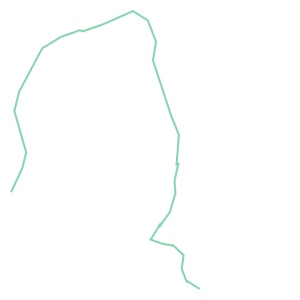

In [24]:
# ordered list of brown line station coordinates
red_line_stations_gdf['coordinates'] = red_line_stations_gdf['geometry_y'].centroid
red_line_stations_gdf


# create a linestring for the brown line route
from shapely.geometry import LineString
red_line_route = LineString(red_line_stations_gdf['coordinates'])
red_line_route

In [25]:
buffered_red_line = red_line_route.buffer(buffer_distance)

overlap_distance_output_red = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_red_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output_red.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'North-South Line'
            })
    else:
        overlap_distance_output_red.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'North-South Line'
            })

overlap_distance_red = pd.DataFrame(overlap_distance_output_red)
overlap_distance_red

724it [00:00, 4973.54it/s]


,Bus Service,Direction,Overlap Distance,MRT line
0,10,1,395.674840,North-South Line
1,10,2,402.819532,North-South Line
2,100,1,395.674840,North-South Line
3,100,2,402.930599,North-South Line
4,100A,1,0.000000,North-South Line
...,...,...,...,...
719,992,1,341.661387,North-South Line
720,992,2,367.918292,North-South Line
721,993,1,0.000000,North-South Line
722,9A,1,0.000000,North-South Line


In [26]:
bus_routes_overlap_red = overlap_distance_red[overlap_distance_red['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_red

,Bus Service,Direction,Overlap Distance,MRT line
666,965,1,10583.682845,North-South Line
572,858,1,6501.666038,North-South Line
682,972M,1,6287.758118,North-South Line
152,167,2,6209.606483,North-South Line
552,851e,1,5726.875630,North-South Line
...,...,...,...,...
88,138B,1,46.077493,North-South Line
292,269A,1,41.274189,North-South Line
181,177,1,23.956965,North-South Line
602,88B,1,20.204034,North-South Line


In [27]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_red], axis = 0)

In [28]:
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line
349,36,1,13497.671113,Thomson-East Coast Line
351,36B,1,11775.414400,Thomson-East Coast Line
392,47,1,6834.465678,Thomson-East Coast Line
225,196e,1,6707.001743,Thomson-East Coast Line
350,36A,1,6150.759588,Thomson-East Coast Line
...,...,...,...,...
88,138B,1,46.077493,North-South Line
292,269A,1,41.274189,North-South Line
181,177,1,23.956965,North-South Line
602,88B,1,20.204034,North-South Line
